In [12]:
# import numpy as np
# import pylab as plt
# import fitsio
# import healpy as hp
# import matplotlib
# import pandas as pd

# import skymap
# from skymap.utils import setdefaults

# from skymap import SurveyMcBryde
# SkymapCls,suffix = SurveyMcBryde,'_mbt'


In [3]:
map_dir = '/project/chihway/data/decade/SP_maps/'

/home/chihway/.conda/envs/shear/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/chihway/.conda/envs/shear/lib/python3.9/site-packages/mpl_toolkits/basemap/__init__.py:4794: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


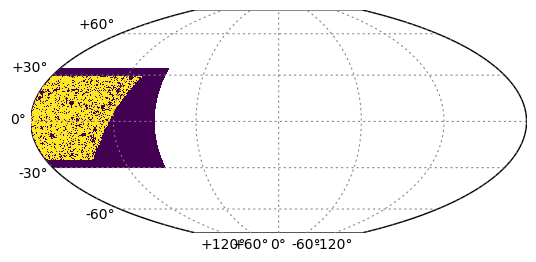

In [12]:

wmap_map_raw = hp.read_map("/project/chihway/data/decade/SP_maps/mcal/ncounts_20230613.fits")
# ext_map = hp.pixelfunc.ud_grade(wmap_map_raw,nside)

#hpxmap_ext = (ext_map  < 0.2)

wmap_map_raw[wmap_map_raw>0] = 1
smap = SkymapCls()
#smap.draw_des()
smap.draw_hpxmap(wmap_map_raw, lonra=(90,180), latra=(-30,35));
plt.show()

In [6]:
help(smap.draw_hpxmap)

Help on method draw_hpxmap in module skymap.core:

draw_hpxmap(hpxmap, pixel=None, nside=None, xsize=800, lonra=None, latra=None, badval=-1.6375e+30, smooth=None, **kwargs) method of skymap.survey.SurveyMcBryde instance
    Use pcolor/pcolormesh to draw healpix map.
    
    Parameters:
    -----------
    hpxmap: input healpix map
    pixel:  explicit pixel indices (required for partial maps)
    nside:  explicit nside of the map (required for partial maps)
    xsize:  resolution of the output image
    lonra:  longitude range [-180,180] (deg)
    latra:  latitude range [-90,90] (deg)
    badval: set of values considered "bad"
    smooth: gaussian smoothing kernel (deg)
    
    Returns:
    --------
    im,lon,lat,values : mpl image with pixel longitude, latitude (deg), and values



In [1]:
import sys
import numpy as np
import astropy.io.fits as pf
import pylab as mplot
import h5py
import healpy as hp

sys.path.insert(0,'/project2/chihway/code/destest')
sys.path.insert(0,'/project/chihway/chihway/y3-6x2pt-new/y3-6x2pt/measurement/src')
import yaml
import destest
import catalog_utils
import shutil

import skyproj
import matplotlib

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

### Read in DELVE catalog

In [3]:
tag = '20240209'
project_dir = '/project/chihway/data/decade/'
master_cat = project_dir+'metacal_gold_combined_'+tag+'.hdf'
master_mask = project_dir+'metacal_gold_combined_mask_'+tag+'.hdf'

In [4]:
with h5py.File(master_cat, 'r') as h5r:
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]
    mask_noshear = h5r['baseline_mcal_mask_noshear'][:]

In [5]:
mask_noshear_nontomo = (mask_noshear>0)
ra = ra[mask_noshear_nontomo]
dec = dec[mask_noshear_nontomo]

In [6]:
nside = 1024
map_counts_delve = np.zeros(hp.nside2npix(nside))

phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

unique_pix, idx_rep = np.unique(pix, return_inverse=True)
map_counts_delve[unique_pix] += np.bincount(idx_rep)


### Read in DES catalog

In [7]:
# Read yaml file that defines all the catalog selections used
params = yaml.load(open('/project/chihway/data/des_y3_catalogs/y3kp_sample/Feb2021/cats.yaml'), Loader=yaml.BaseLoader)
params['param_file'] = 'cats.yaml'

source_selector, source_calibrator = catalog_utils.load_catalog(params, 'mcal', 'mcal', 
                params['source_group'], params['source_table'], params['source_path'], 
                return_calibrator=destest.MetaCalib)

des_ra = source_selector.get_col('ra', uncut=True)[0][source_selector.get_mask()[0]]
des_dec = source_selector.get_col('dec', uncut=True)[0][source_selector.get_mask()[0]]


['T', 'T_err', 'covmat_0_1', 'covmat_1_1', 'covmat_2_2', 'e_1', 'e_2', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_r', 'flux_z', 'size_ratio', 'snr', 'weight']
loaded mask cache
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
ra not in sheared cols
ra not in sheared cols
ra not in sheared cols
ra not in sheared cols
dec not in sheared cols
dec not in sheared cols
dec not in sheared cols
dec not in sheared cols


In [8]:
map_counts_des = np.zeros(hp.nside2npix(nside))

phi = des_ra/180*np.pi
theta = (90.-des_dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

unique_pix, idx_rep = np.unique(pix, return_inverse=True)
map_counts_des[unique_pix] += np.bincount(idx_rep)

In [9]:
pixarea_arcmin = 4*np.pi*(180/np.pi)**2/hp.nside2npix(nside)*60*60

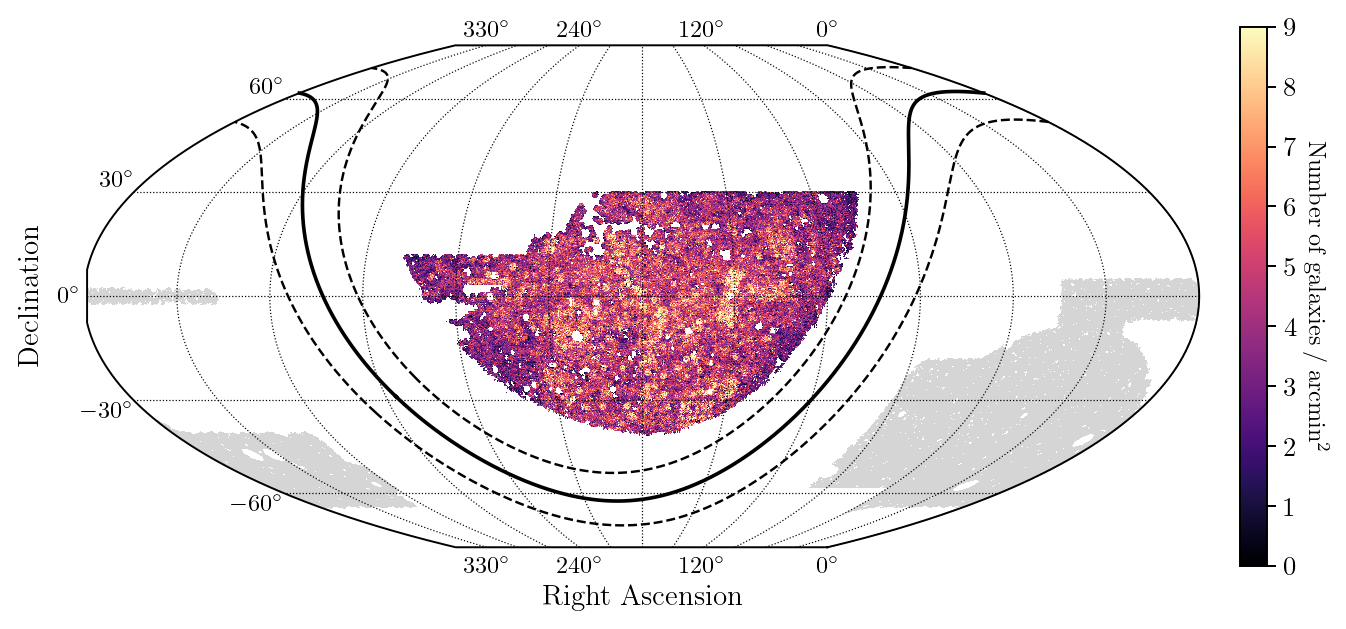

In [10]:
map_counts_delve_show = map_counts_delve.copy()
map_counts_delve_show[map_counts_delve_show!=0] /= pixarea_arcmin
map_counts_delve_show[map_counts_delve_show==0] = hp.UNSEEN

map_counts_des_show = map_counts_des.copy()
map_counts_des_show[map_counts_des_show!=0] = 1
map_counts_des_show[map_counts_des_show==0] = hp.UNSEEN


fig = plt.figure(2, figsize=(10, 4), dpi=175)
fig.clf()

ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(lon_0=180, ax=ax)
# Note that the default is to zoom in to the range defined by the map
sp.draw_hpxmap(map_counts_des_show, zoom=False, vmin=0, vmax=1.2, cmap='grey',label='DES')
sp.draw_hpxmap(map_counts_delve_show, zoom=False, vmin=0, vmax=9, label='DELVE', cmap = 'magma')
sp.draw_milky_way(width=10)
sp.ax.set_xlabel("$\\rm Right \; Ascension$", fontsize=12)
sp.ax.set_ylabel("$\\rm Declination$", fontsize=12)

cbar = sp.draw_colorbar(pad = 0.03)
cbar.set_label("$\\rm Number \; of \; galaxies \; / \; arcmin^2$", rotation=270, labelpad=13)

plt.savefig('decam_des.pdf', facecolor="white", bbox_inches='tight')


In [12]:
hsc_mask = hp.read_map('/project/chihway/data/txpipe_hsc/mask1024.fits')
kids_mask = hp.read_map('/project/chihway/data/kids/mask_kids1000.fits')

In [37]:
hsc_mask_show = hsc_mask.copy()
hsc_mask_show[hsc_mask_show==0] = hp.UNSEEN

kids_mask_show = kids_mask.copy()
kids_mask_show[kids_mask_show==0] = hp.UNSEEN


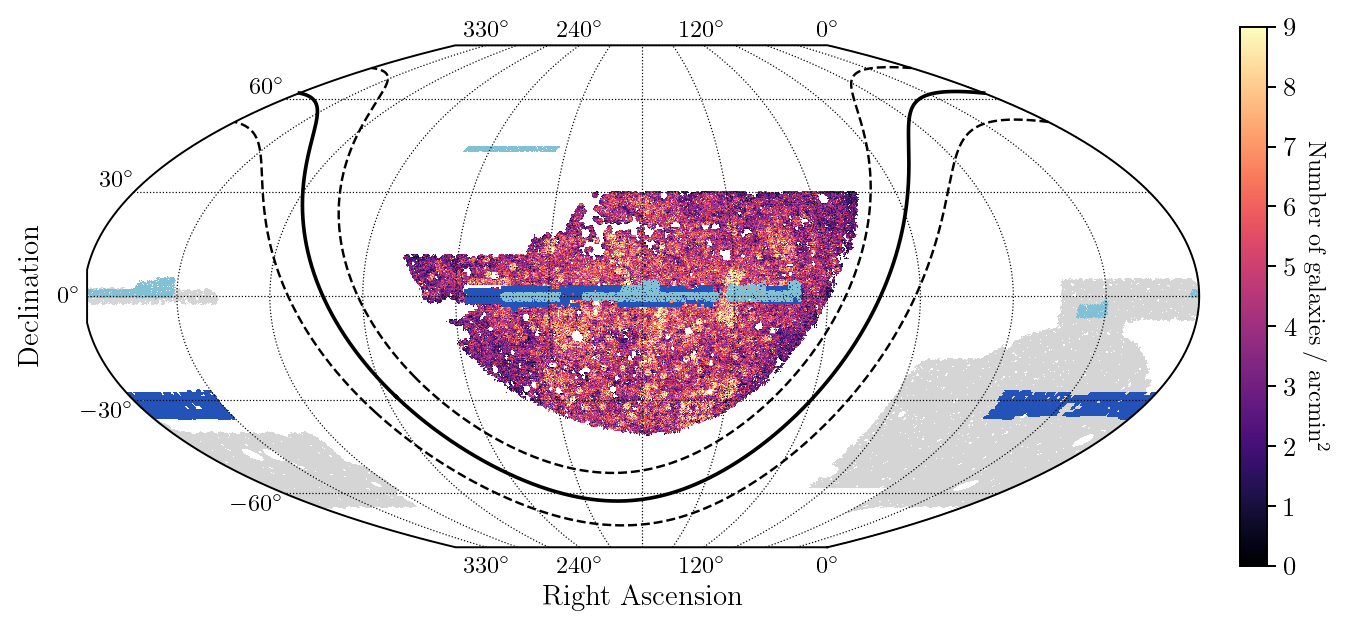

In [46]:


fig = plt.figure(2, figsize=(10, 4), dpi=175)
fig.clf()

ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(lon_0=180, ax=ax)
# Note that the default is to zoom in to the range defined by the map
sp.draw_hpxmap(map_counts_des_show, zoom=False, vmin=0, vmax=1.2, cmap='grey',label='DES')
sp.draw_hpxmap(map_counts_delve_show, zoom=False, vmin=0, vmax=9, label='DELVE', cmap = 'magma')
cbar = sp.draw_colorbar(pad = 0.03)

sp.draw_hpxmap(kids_mask_show, zoom=False, vmin=0, vmax=20, cmap='terrain',label='DES')
sp.draw_hpxmap(hsc_mask_show, zoom=False, vmin=0, vmax=1.2, cmap='ocean',label='DES')

sp.draw_milky_way(width=10)
sp.ax.set_xlabel("$\\rm Right \; Ascension$", fontsize=12)
sp.ax.set_ylabel("$\\rm Declination$", fontsize=12)


cbar.set_label("$\\rm Number \; of \; galaxies \; / \; arcmin^2$", rotation=270, labelpad=13)

plt.savefig('decam_des.pdf', facecolor="white", bbox_inches='tight')


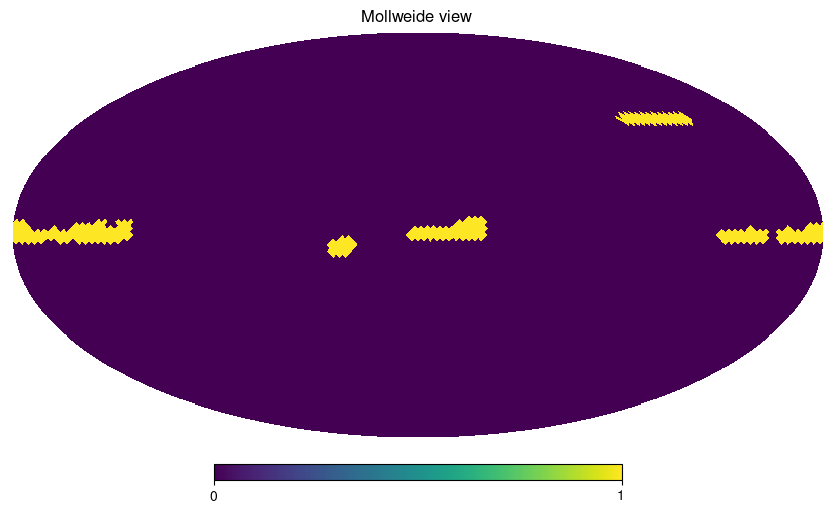

In [18]:
hsc2 = hp.ud_grade(hsc_mask, nside_out=32)
hsc2[hsc2>0] = 1
hp.mollview(hsc2)

In [19]:
pix = np.arange(len(hsc2))
pix_one = pix[hsc2==1]
theta, phi = hp.pix2ang(32, pix_one)
print(len(pix_one))
pix_b = []
for i in range(len(pix_one)):
    pix_n = hp.get_all_neighbours(32, theta[i], phi[i])
    if len(pix_n[hsc2[pix_n]==0])>0:
        pix_b.append(pix_one[i])

291


In [22]:
print(len(pix_b))

247


In [25]:
t,p = hp.pix2ang(32, pix_b)

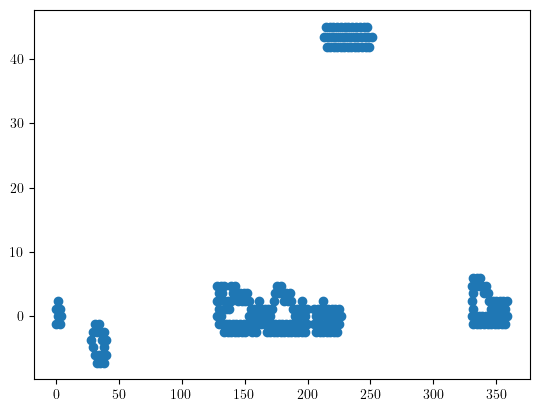

In [29]:
plt.scatter(p/np.pi*180,90-t/np.pi*180)